<center>
<img src="https://habrastorage.org/web/677/8e1/337/6778e1337c3d4b159d7e99df94227cb2.jpg"/>
## Специализация "Машинное обучение и анализ данных"
</center>
<center>Автор материала: программист-исследователь Mail.ru Group, старший преподаватель Факультета Компьютерных Наук ВШЭ Юрий Кашницкий

# <center>  Capstone проект №1. Идентификация пользователей по посещенным веб-страницам
<img src='http://i.istockimg.com/file_thumbview_approve/21546327/5/stock-illustration-21546327-identification-de-l-utilisateur.jpg'>

# <center>Неделя 3. Визуальный анализ данных и построение признаков

На 3 неделе мы займемся визуальным анализом данных и построением признаков. Сначала мы вместе построим и проанализируем несколько признаков, потом Вы сможете сами придумать и описать различные признаки. Задание имеет вид Peer-Review, так что творчество здесь активно приветствуется. Если задействуете IPython-виджеты, библиотеку Plotly, анимации и прочий интерактив, всем от этого будет только лучше.

**План 3 недели:**
 - Часть 1. Построение признаков
 - Часть 2. Визуальный анализ данных
 - Часть 3. Дальнейшее построение признаков
 - Часть 4. Проверка построенных признаков

**В этой части проекта Вам могут быть полезны видеозаписи следующих лекций курса "Поиск структуры в данных":**
   - [Задача визуализации](https://www.coursera.org/learn/unsupervised-learning/lecture/hlvlT/zadacha-vizualizatsii)
   - [Визуализация данных в sklearn](https://www.coursera.org/learn/unsupervised-learning/lecture/ityMo/vizualizatsiia-dannykh-v-sklearn)
   
**Также в задании будет использоваться библиотека Seaborn (ее можно дополнительно установить командой *pip install seaborn*), будет полезно обращаться к документациям [Matplotlib](http://matplotlib.org/users/) и [Seaborn](http://seaborn.pydata.org/), а также к примерам визуализации, описанным на StackOverflow.**



## Часть 1. Построение признаков

In [1]:
from __future__ import division, print_function
# отключим всякие предупреждения Anaconda
import warnings
warnings.filterwarnings('ignore')
from glob import glob
import os
from tqdm import tqdm_notebook
import numpy as np
import pandas as pd
pd.set_option('display.max.columns', 25)
import pickle
#pip install seaborn
import seaborn as sns
%matplotlib inline
from matplotlib import pyplot as plt
from tqdm import tqdm

In [2]:
pd.set_option('display.max_rows', 200)
pd.set_option('display.max_columns', 100)
pd.set_option('display.width', 250)
pd.set_option('max_colwidth', 100)

In [3]:
# Поменяйте на свой путь к данным
PATH_TO_DATA = 'capstone_user_identification'

**Создайте на основе функций *prepare_train_set* и *prepare_sparse_train_set_window*  новую – *prepare_train_set_with_fe*, (от "feature engineering"), создайте следующие признаки:**
- `session_timespan` – продолжительность сессии (разница между максимальным и минимальным временем посещения сайтов в сессии, в секундах)
- `#unique_sites` – число уникальных сайтов в сессии 
- `start_hour` – час начала сессии (то есть час в записи минимального timestamp среди десяти)
- `day_of_week` – день недели (то есть день недели в записи минимального timestamp среди десяти)

Функция должна возвращать новый DataFrame (как возвращала функция *prepare_train_set*), только признаков должно быть на 4 больше. Порядок, в котором добавляются признаки: *site1*, ... *site10*, *session_timespan*, *#unique_sites*, *start_hour*, *day_of_week* и *user_id* (это видно и чуть ниже по тому, как функция вызывается).

In [57]:
# Довольно странный пример, потому что есть дополнительные признаки, про которые выше ничего не сказано. 
# И userid становится target. Переименуем здесь userid в target и рассчитаем новые признаки
def prepare_train_set_with_fe(path_to_csv_files, site_freq_path, feature_names,
                                    session_length=10, window_size=10):
    print('Reading files')
    dfs = []
    for file in tqdm(os.listdir(path_to_csv_files)):
        if file.startswith('user'):
            userid = int(file.replace('user', '').replace('.csv', ''))
            df = pd.read_csv(os.path.join(path_to_csv_files, file), parse_dates=['timestamp'])
            df['userid'] = userid
            dfs.append(df)
            
#     print('Counting site visits')
#     sites = (
#         pd.concat(
#             [pd.DataFrame([{'site': None}])] + [df[['site']] for df in dfs])['site']
#     )

#     site_counts = (
#         sites
#         .value_counts()
#         .reset_index()
#         .rename(columns={'site': 'count', 'index': 'site'})
#     )
    
#     unique_sites = (
#         sites
#         .drop_duplicates()
#         .reset_index(drop=True)
#         .reset_index()
#         .merge(site_counts, on='site')
#     )
    
#     sites_id_freq = {}
#     site_to_id = {}
#     for _, row in unique_sites.sort_values(by='site').iterrows():
#         sites_id_freq[row['site']] = (row['index'], row['count'])
#         site_to_id[row['site']] = row['index']

    with open(site_freq_path, 'rb') as f:
        sites_id_freq = pickle.load(f)
        
    site_to_id = {k: v[0] for k, v in sites_id_freq.items()}
        
        
    print('Collecting session stats')
    sessions = []
    for df in dfs:
        userid = df['userid'][0]        
        df['siteid'] = df['site'].map(site_to_id)
        start = 0
        while start < len(df):
            session = df[start:start+session_length].copy()
            start_time = min(session['timestamp'])
            timespan = max(session['timestamp'] - min(session['timestamp'])).seconds
            unique_sites = len(session['siteid'].unique())
            start_hr = min(session['timestamp']).hour
            dow = min(session['timestamp']).weekday()
            if len(session) < session_length:
                add_length = session_length - len(session)
                session = pd.concat([session, pd.DataFrame(add_length * [{'siteid': 0, 'userid': userid, 'timestamp': max(session['timestamp'])}])])
            session = session.reset_index(drop=True)
            # Хотя это и не требуется, в примере есть эти данные. Рассчитаем продолжительность пребывания на одном сайте
            timediff = session['timestamp'].diff()[1:].map(lambda x: x.seconds).values.tolist()
            session = np.array(session['siteid'].values.tolist() + [session.loc[0, 'userid'], timespan, unique_sites, start_hr, dow, start_time] + timediff)
            sessions.append(session)
            start += window_size
        df = None
        
    sessions = np.vstack(sessions)
    columns = (
        [f'site{i + 1}' for i in range(session_length)] 
        + ['userid', 'session_timespan', '#unique_sites', 'start_hour', 'day_of_week', 'start_time']
        + [f'time_diff{i + 1}' for i in range(session_length - 1)] 
    )
    sessions = pd.DataFrame(sessions, columns=columns)
    feature_names = [name for name in feature_names if name in columns]
    sessions = sessions[feature_names]
    return sessions  #, sites_id_freq

**Проверим функцию на игрушечном примере.**

In [58]:
feature_names = ['site' + str(i) for i in range(1,11)] + \
                ['time_diff' + str(j) for j in range(1,10)] + \
                ['session_timespan', '#unique_sites', 'start_hour', 
                 'day_of_week', 'start_time', 'userid']
train_data_toy  = prepare_train_set_with_fe(os.path.join(PATH_TO_DATA, 
                                                         '3users'), 
                  site_freq_path=os.path.join(PATH_TO_DATA, 
                                              'site_freq_3users.pkl'),
                  feature_names=feature_names, session_length=10)

100%|██████████| 4/4 [00:00<00:00, 330.29it/s]

Reading files


In [59]:
train_data_toy

,site1,site2,site3,site4,site5,site6,site7,site8,site9,site10,time_diff1,time_diff2,time_diff3,time_diff4,time_diff5,time_diff6,time_diff7,time_diff8,time_diff9,session_timespan,#unique_sites,start_hour,day_of_week,start_time,userid
0,1,2,2,3,2,4,5,6,7,8,287,1184,6278,186,2,1,2,3,55,7998,8,9,4,2013-11-15 09:28:17,1
1,1,4,4,4,0,0,0,0,0,0,2,3,55,0,0,0,0,0,0,60,2,12,4,2013-11-15 12:40:35,1
2,1,2,9,9,2,0,0,0,0,0,287,1184,6278,186,0,0,0,0,0,7935,3,9,4,2013-11-15 09:28:17,2
3,10,4,2,4,2,4,4,6,11,10,287,1184,6278,186,2,1,2,3,55,7998,5,9,4,2013-11-15 09:28:17,3
4,10,4,2,0,0,0,0,0,0,0,287,1184,0,0,0,0,0,0,0,1471,3,12,4,2013-11-15 12:28:17,3


**Примените функцию *prepare_train_set_with_fe* к данным по 10 пользователям, укажите *session_length*=10.**

In [60]:
%%time
train_data_10users = prepare_train_set_with_fe(os.path.join(PATH_TO_DATA, '10users'), 
                  site_freq_path=os.path.join(PATH_TO_DATA, 'site_freq_10users.pkl'),
                  feature_names=feature_names, session_length=10)

100%|██████████| 11/11 [00:00<00:00, 60.52it/s]

Reading files


CPU times: user 27.5 s, sys: 16.6 ms, total: 27.6 s
Wall time: 27.6 s


In [61]:
train_data_10users.head()

,site1,site2,site3,site4,site5,site6,site7,site8,site9,site10,time_diff1,time_diff2,time_diff3,time_diff4,time_diff5,time_diff6,time_diff7,time_diff8,time_diff9,session_timespan,#unique_sites,start_hour,day_of_week,start_time,userid
0,1,1,2,3,4,3,5,5,6,7,2,1,61,1,0,222,1184,1574,4698,7743,7,9,4,2013-11-15 09:28:17,50
1,7,8,9,10,9,9,9,11,12,13,5,7,1,3,1,4,12,0,1,34,7,11,4,2013-11-15 11:37:21,50
2,14,15,15,7,16,17,18,19,20,21,0,1,7,131,2,1,2,3,37,184,9,11,4,2013-11-15 11:38:13,50
3,21,22,23,24,22,25,19,22,14,15,17,103,240,97,7,186,517,538,0,1705,8,11,4,2013-11-15 11:41:18,50
4,15,22,22,22,14,15,22,22,25,22,61,601,601,485,1,114,600,365,235,3063,4,12,4,2013-11-15 12:09:44,50


**Примените функцию *prepare_train_set_with_fe* к данным по 150 пользователям, укажите *session_length*=10.**

In [62]:
%%time
train_data_150users = prepare_train_set_with_fe(os.path.join(PATH_TO_DATA, '150users'), 
                  site_freq_path=os.path.join(PATH_TO_DATA, 'site_freq_150users.pkl'),
                  feature_names=feature_names, session_length=10)

  5%|▍         | 7/151 [00:00<00:02, 61.24it/s]

Reading files


100%|██████████| 151/151 [00:01<00:00, 76.52it/s]


CPU times: user 4min 16s, sys: 301 ms, total: 4min 17s
Wall time: 4min 17s


**Сохраните в pickle-файлы признаки *session_timespan*, *#unique_sites*, *start_hour* и *day_of_week* для 10 и 150 пользователей.**

In [10]:
new_features_10users = train_data_10users[['session_timespan', '#unique_sites', 'start_hour', 'day_of_week']]
new_features_150users = train_data_150users[['session_timespan', '#unique_sites', 'start_hour', 'day_of_week']]

In [11]:
with open(os.path.join(PATH_TO_DATA, 
                       'new_features_10users.pkl'), 'wb') as new_features_10users_pkl:
    pickle.dump(new_features_10users, new_features_10users_pkl)
with open(os.path.join(PATH_TO_DATA, 
                       'new_features_150users.pkl'), 'wb') as new_features_150users_pkl:
    pickle.dump(new_features_150users, new_features_150users_pkl)

## Часть 2. Визуальный анализ данных

**Забавы ради, для потехи дадим пользователям имена и ассоциируем с ними цвета.**

In [14]:
id_name_dict = {128: 'Mary-Kate', 39: 'Ashley', 207: 'Lindsey', 127: 'Naomi', 237: 'Avril',
               33: 'Bob', 50: 'Bill', 31: 'John', 100: 'Dick', 241: 'Ed'}
train_data_10users['userid'] = train_data_10users['userid'].map(id_name_dict)

In [15]:
color_dic = {'Mary-Kate': 'pink', 'Ashley': 'darkviolet', 'Lindsey':'blueviolet', 
             'Naomi': 'hotpink', 'Avril': 'orchid', 
             'Bob': 'firebrick', 'Bill': 'gold', 'John': 'forestgreen', 
             'Dick': 'slategrey', 'Ed':'brown'}

**1. Постройте гистограмму распределения длины сессии в секундах (*session_timespan*). Ограничьте по *x* значением 200 (иначе слишком тяжелый хвост). Сделайте гистограмму цвета *darkviolet*, подпишите оси по-русски.**

Text(0, 0.5, 'Число сессий')

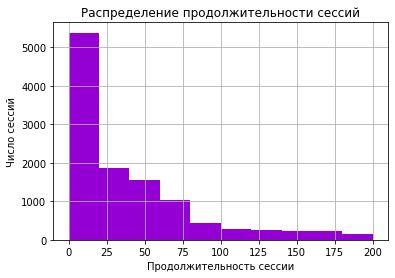

In [16]:
train_data_10users[train_data_10users['session_timespan'] <= 200]['session_timespan'].hist(color='darkviolet')
plt.title('Распределение продолжительности сессий')
plt.xlabel('Продолжительность сессии')
plt.ylabel('Число сессий')

**2. Постройте гистограмму распределения числа уникальных сайтов в сессии (*#unique_sites*). Сделайте гистограмму цвета *aqua*, подпишите оси по-русски.**

Text(0, 0.5, 'Число сессий')

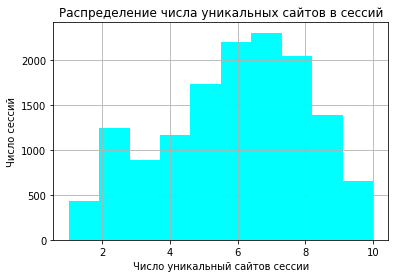

In [17]:
train_data_10users['#unique_sites'].hist(color='aqua')
plt.title('Распределение числа уникальных сайтов в сессий')
plt.xlabel('Число уникальный сайтов сессии')
plt.ylabel('Число сессий')

**3. Постройте гистограммы распределения числа уникальных сайтов в сессии (*#unique_sites*) для каждого из 10 пользователей по отдельности. Используйте *subplots*, чтоб разместить все 10 картинок на одной большой. Пометьте легендой каждую картинку, на легенде должно быть написано имя пользователя. Для каждого пользователя раскрасьте гистограмму его/ее цветом (*color_dic*). Подпишите оси по-русски в каждой из 10 гистограмм.**

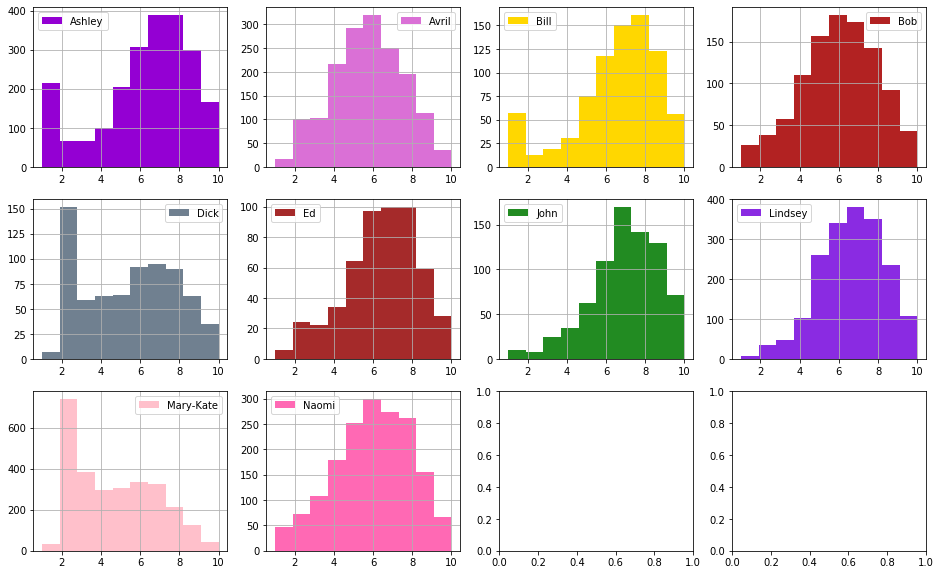

In [18]:
fig, axes = plt.subplots(nrows=3, ncols=4, figsize=(16, 10))

# как вариант, можно и по-другому
for idx, (user, sub_df) in  enumerate(train_data_10users.groupby('userid')): 
    ax = axes[idx // 4, idx % 4]
    sub_df['#unique_sites'].hist(ax=ax, color=color_dic[user])
    ax.legend([user])

**4. Постройте гистограмму распределения часа начала сессии (*start_hour*). Сделайте гистограмму цвета *darkgreen*, подпишите оси по-русски.**

Text(0, 0.5, 'Число сессий')

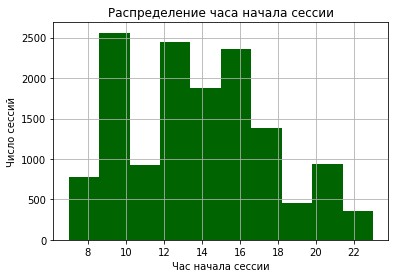

In [19]:
train_data_10users['start_hour'].hist(color='darkgreen')
plt.title('Распределение часа начала сессии')
plt.xlabel('Час начала сессии')
plt.ylabel('Число сессий')

**5. Постройте гистограммы распределения часа начала сессии (*start_hour*) для каждого из 10 пользователей по отдельности. Используйте *subplots*, чтоб разместить все 10 картинок на одной большой. Пометьте легендой каждую картинку, на легенде должно быть написано имя пользователя. Для каждого пользователя раскрасьте гистограмму его/ее цветом (*color_dic*). Подпишите оси по-русски в каждой из 10 гистограмм.**

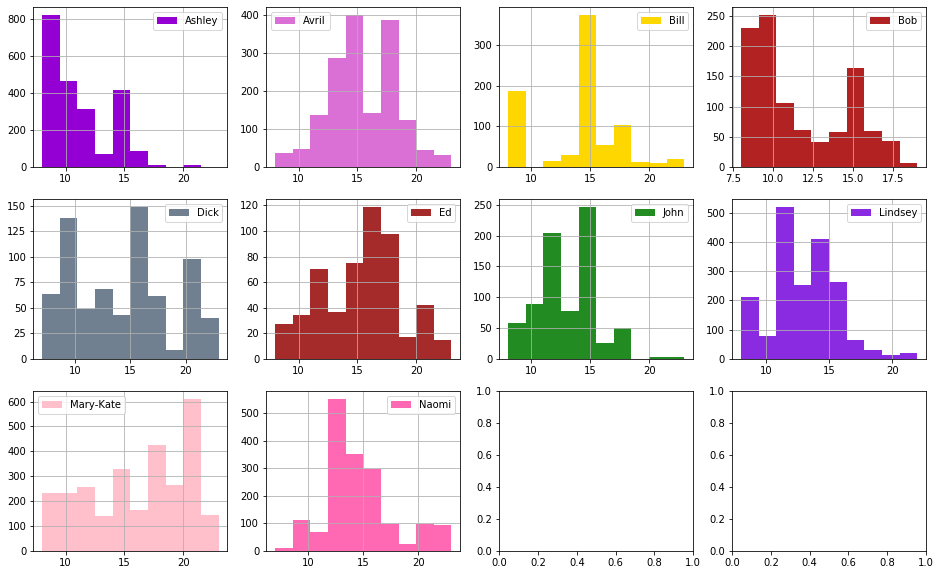

In [20]:
fig, axes = plt.subplots(nrows=3, ncols=4, figsize=(16, 10))

# как вариант, можно и по-другому
for idx, (user, sub_df) in  enumerate(train_data_10users.groupby('userid')): 
    ax = axes[idx // 4, idx % 4]
    sub_df['start_hour'].hist(ax=ax, color=color_dic[user])
    ax.legend([user])

**6. Постройте гистограмму распределения дня недели, в который началась сессия (*day_of_week*). Сделайте гистограмму цвета *sienna*, подпишите оси по-русски.**

Text(0, 0.5, 'Число сессий')

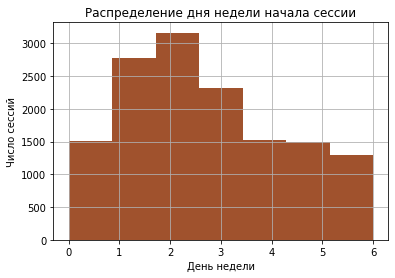

In [21]:
# В неделе 7 дней. Сделаем соответствующее количество столбцов в гистограмме
train_data_10users['day_of_week'].hist(color='sienna', bins=7)
plt.title('Распределение дня недели начала сессии')
plt.xlabel('День недели')
plt.ylabel('Число сессий')

**7. Постройте гистограммы распределения дня недели, в который началась сессия (*day_of_week*) для каждого из 10 пользователей по отдельности. Используйте *subplots*, чтоб разместить все 10 картинок на одной большой. Измените метки по оси *X* на ['Пн', 'Вт', 'Ср', 'Чт', 'Пт', 'Сб', 'Вс'] – метод *set_xticklabels*. Пометьте легендой каждую картинку, на легенде должно быть написано имя пользователя. Для каждого пользователя раскрасьте гистограмму его/ее цветом (*color_dic*). Подпишите по-русски название каждой из 10 гистограмм.**

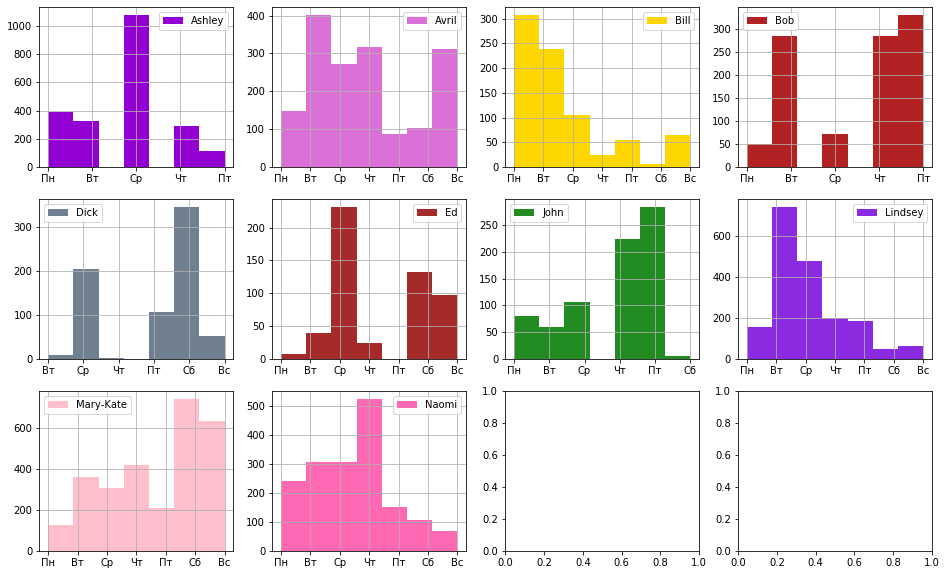

In [22]:
fig, axes = plt.subplots(nrows=3, ncols=4, figsize=(16, 10))

# как вариант, можно и по-другому
for idx, (user, sub_df) in  enumerate(train_data_10users.groupby('userid')):
    ax = axes[idx // 4, idx % 4]
    ax.set_xticks([0, 1, 2, 3, 4, 5, 6])
    ax.set_xticklabels(['Пн', 'Вт', 'Ср', 'Чт', 'Пт', 'Сб', 'Вс'])
    sub_df['day_of_week'].hist(ax=ax, color=color_dic[user], bins=7)
    
    ax.legend([user])

**8. Сделайте выводы про каждого пользователя по построенным графикам.**

- У всех пользователей преобладают короткие сессии
- Ashley начинает сессии утром (примерно в 9-10 часов), второй пик приходится примерно на 15 часов. Основная активность приходится на среду, на выходных нет посещений сайтов. Обычно посещает либо один сайт за сессию, либо примерно 7-8 (бимодальное распределение)
- Avril, в основном, заходит в середине дня, очень редко утром или вечером. Посещает за сессию в среднем 6 сайтов.
- Bill чаще всего заходит днем (в 15 часов), или утром (реже). Активность максимальная в понедельник, к воскресенью уменьшается. Посещает либо один сайт, дибо примерно 8.
- Bob активен по будням, в основном в пн, чт и пт, больная активность с утра. Не посещает сайты в выходные дни. В среднем посещает 6 сайтов за сессию.
- Dick активен в течение всего дня, больще всего сб и ср. Сессии часто состоят из 2 уникальных сайтов.
- Ed более активен в середине дня. Активен в течение всей недели, но более всего в ср, сб и вс. Сессии по 6-8 уникальных сайтов
- John наиболее активен в 12-15 часов. Наибольная активность в будни, особенно в чт и пт. Сессии преимущественно по 7-8 сайтов.
- Lindsey наиболее активна в 11-16 часов. Сидит в интернете всю неделю, но наибольшая активность во вт и ср. Преимущественно 7-8 сайтов в сессии.
- Mary-Kate активна в течение всего дня, к вечеру активность увеличивается. Активна в течение всей недели, более всего - в выходные.  Чаще встречаются сессии из 2 уникальных сайтов
- Naomi активна в течение дня но больше всего в середине. Активна всю неделю, наиболее активна в среду. Сессии в среднем состоят из 6-8 уникальных сайтов.

**Загрузите сохраненный ранее в pickle-файл частотный словарь сайтов для 10 пользователей. **

In [23]:
with open(os.path.join(PATH_TO_DATA, 'site_freq_10users.pkl'), 'rb') as f:
    sites_freq = pickle.load(f)
sites_freq = pd.DataFrame(sites_freq).transpose().reset_index()
sites_freq.columns = ['site', 'site_id', 'freq']

In [24]:
sites_freq.head()

,site,site_id,freq
0,0.docs.google.com,1550,26
1,0.drive.google.com,1553,49
2,0.gravatar.com,146,76
3,0.talkgadget.google.com,1551,5
4,0.tqn.com,924,3


**Определите топ-10 самых посещаемых сайтов (*top10_sites*) и соответствующие кол-ва посещений (*top10_freqs*).**

In [25]:
top10_freqs = sites_freq.sort_values(by='freq', ascending=False)['freq'][:10]
top10_sites = sites_freq.sort_values(by='freq', ascending=False)['site'][:10]

**9. Нарисуйте *seaborn barplot*, показывающий частоты посещений топ-10 сайтов. Сделайте подписи сайтов вертикальными, иначе они сливаются (*xticks*).**

(array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]), <a list of 10 Text xticklabel objects>)

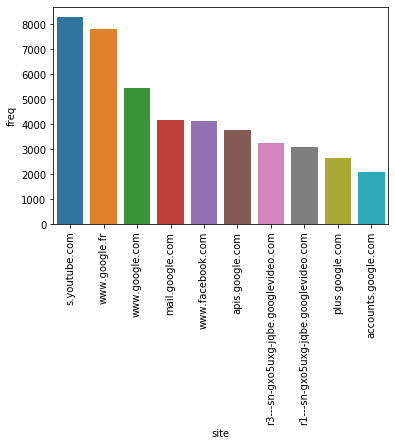

In [26]:
sns.barplot(x=top10_sites, y=top10_freqs)
plt.xticks(rotation=90)

## Часть 3. Проверка построенных признаков
Эта часть скорее техническая, смысл ее – убедиться, что мы все одинаково создали признаки *session_timespan, #unique_sites, start_hour* и *day_of_week*.

**10. Выведите медианную продолжительность сессии (*session_timespan*) для сессий 10 пользователей.**

In [27]:
train_data_10users['session_timespan'].median()

37.0

**11. Выведите медианный день недели, в который началась сессия, для сессий 10 пользователей.**

In [28]:
train_data_10users['day_of_week'].median()

2.0

**12. Выведите медианный час начала сессии для сессий 150 пользователей.**

In [29]:
train_data_150users['start_hour'].median()

13.0

**13. Выведите медианное значение числа уникальных сайтов в сессиях 150 пользователей.**

In [30]:
train_data_150users['#unique_sites'].median()

7.0

## Часть 4. Дальнейшее построение признаков

Это задание творческое, тут надо придумать, как еще учесть время посещения веб-страниц и прочие признаки. 

На следующей неделе мы будем использовать "мешок" сайтов  для классификации сессий по принадлежности разным пользователям, а эти новые признаки, которые Вы сейчас создадите, потом добавим и посмотрим, улучшается ли модель. Поэтому можно их создать в виде отдельных матриц и сохранить их также отдельно.  

В этой части задания Вы можете построить и визуально исследовать самые разные признаки (ничто фантазию не ограничивает):
- год, месяц и день начала сессии
- час начала сессии (с учетом года, месяца и дня)
- время суток
- среднее время пребывания на сайте, посчитать можно, скажем, для топ-30 популярных сайтов
- индикаторы посещения популярных сайтов (скажем, тоже для топ-30 популярных сайтов)
- частота посещения Facebook
- ...

**Напишите функцию для создания новых признаков и примените ее к исходным данным – каталогам с 10 и 150 файлами. Сделайте это только для набора данных, полученного с параметрами *session_length=10* и *window_size=10*. Сериализуйте полученные матрицы с помощью pickle. Функция может возвращать как только новые признаки, так и старые с новыми. При этом сигнатура функции может быть другой – тут уже свобода выбора.**

In [63]:
def feature_engineering(data):
    data['start_year'] = data['start_time'].map(lambda x: x.year)
    data['start_month'] = data['start_time'].map(lambda x: x.month)
    data['start_day'] = data['start_time'].map(lambda x: x.day)
    # Разобьем день по 6 часов
    def timeofday(x):
        if x >= 0 and x < 6:
            return 'night'
        elif x >= 6 and x < 12:
            return 'morning'
        elif x >= 12 and x < 18:
            return 'day'
        else:
            return 'evening'
    data['time_of_the_day'] = data['start_hour'].map(timeofday)
    data['weekend'] = data['day_of_week'].map(lambda x: 1 if x > 5 else 0)
    # Не совсем честно, надо бы исключить нули. Но это будет видно, когда начнем обучать модель.
    data['mean_site_time'] = data[[column for column in data.columns if 'diff' in column]].mean(axis=1)
    data['median_site_time'] = data[[column for column in data.columns if 'diff' in column]].median(axis=1)
    return data

In [64]:
new_features_10users = feature_engineering(train_data_10users)

In [66]:
new_features_10users.head()

,site1,site2,site3,site4,site5,site6,site7,site8,site9,site10,time_diff1,time_diff2,time_diff3,time_diff4,time_diff5,time_diff6,time_diff7,time_diff8,time_diff9,session_timespan,#unique_sites,start_hour,day_of_week,start_time,userid,start_year,start_month,start_day,time_of_the_day,weekend,mean_site_time,median_site_time
0,1,1,2,3,4,3,5,5,6,7,2,1,61,1,0,222,1184,1574,4698,7743,7,9,4,2013-11-15 09:28:17,50,2013,11,15,morning,0,860.333333,61.0
1,7,8,9,10,9,9,9,11,12,13,5,7,1,3,1,4,12,0,1,34,7,11,4,2013-11-15 11:37:21,50,2013,11,15,morning,0,3.777778,3.0
2,14,15,15,7,16,17,18,19,20,21,0,1,7,131,2,1,2,3,37,184,9,11,4,2013-11-15 11:38:13,50,2013,11,15,morning,0,20.444444,2.0
3,21,22,23,24,22,25,19,22,14,15,17,103,240,97,7,186,517,538,0,1705,8,11,4,2013-11-15 11:41:18,50,2013,11,15,morning,0,189.444444,103.0
4,15,22,22,22,14,15,22,22,25,22,61,601,601,485,1,114,600,365,235,3063,4,12,4,2013-11-15 12:09:44,50,2013,11,15,day,0,340.333333,365.0


In [67]:
new_features_150users = feature_engineering(train_data_150users)

**14. Постройте картинки для новых признаков, поисследуйте их, прокомментируйте результаты.**

start_year


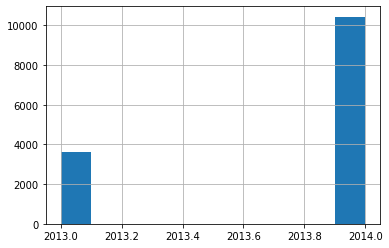

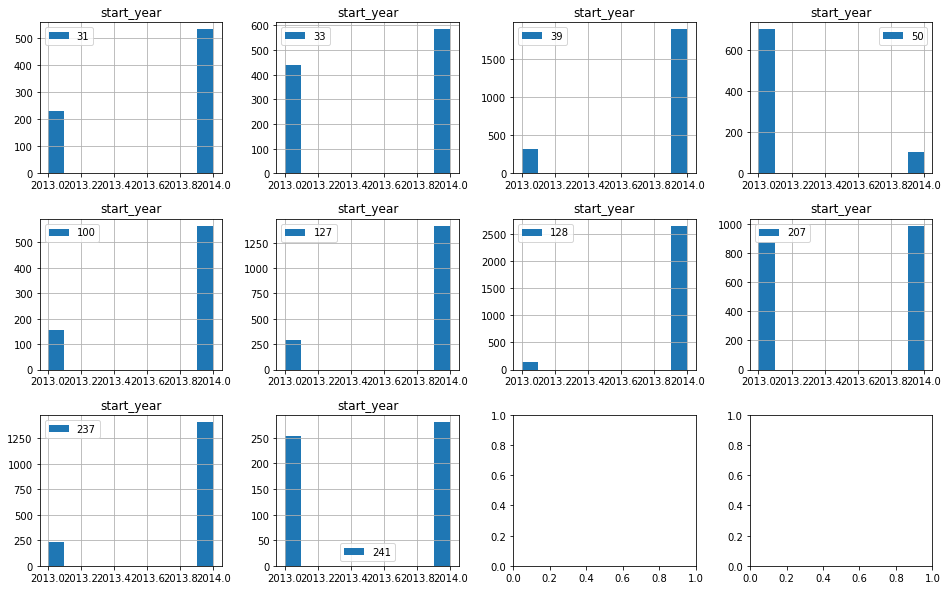

start_month


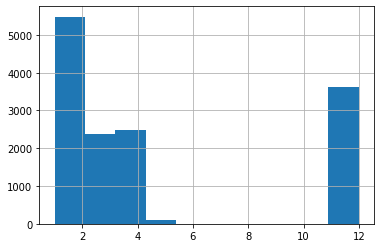

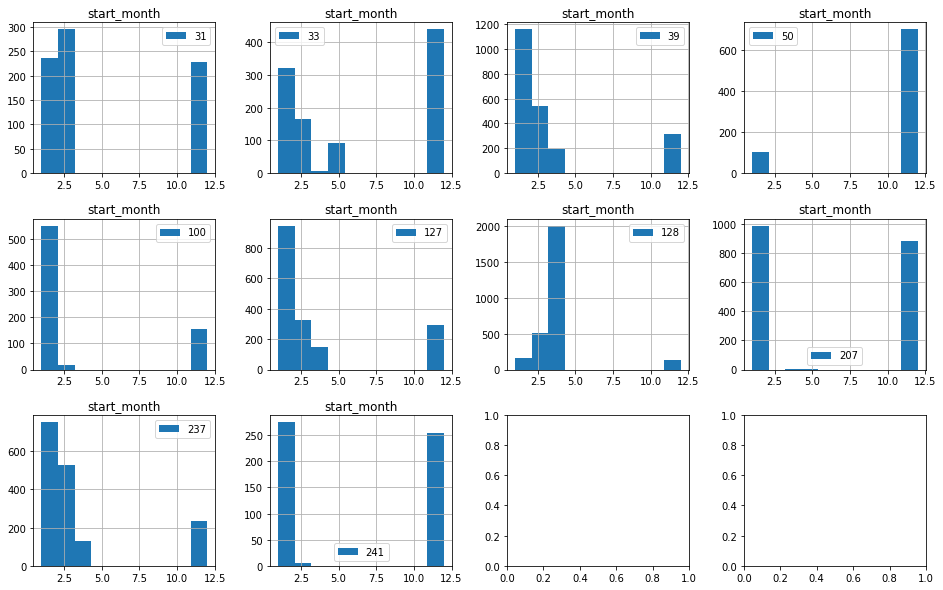

start_day


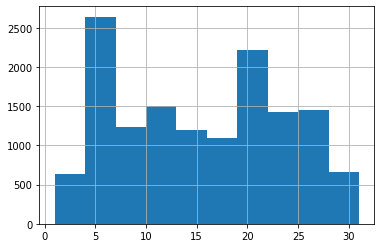

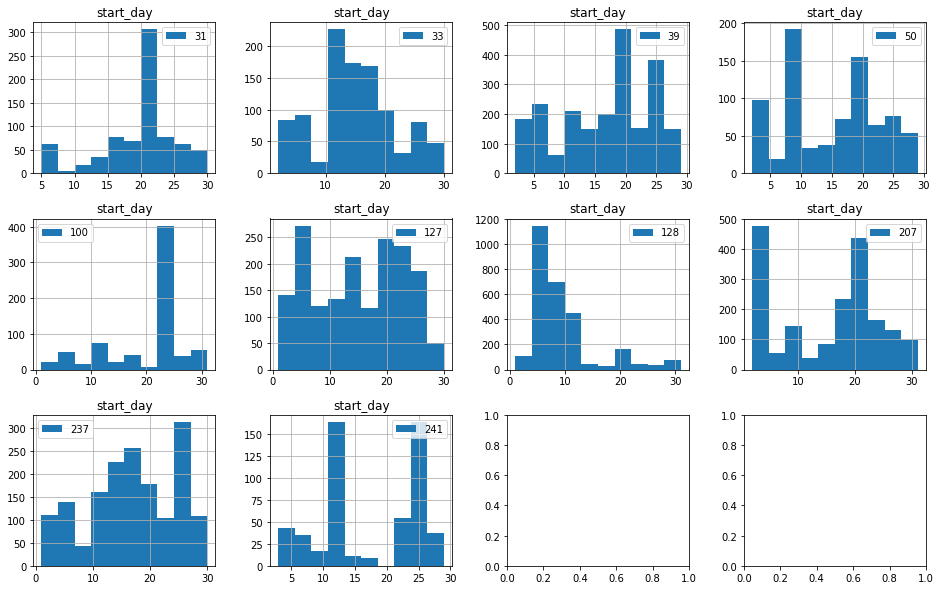

time_of_the_day


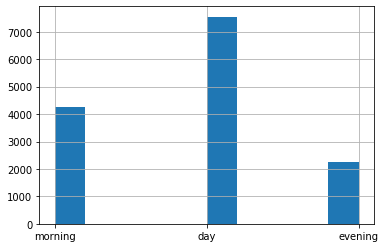

weekend


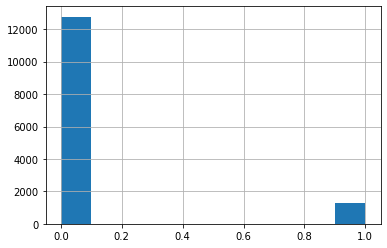

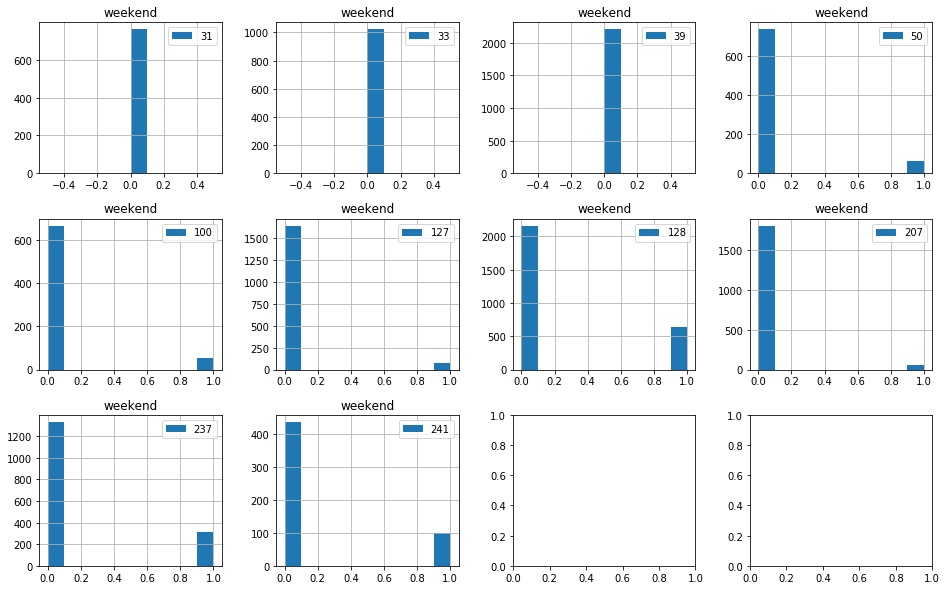

mean_site_time


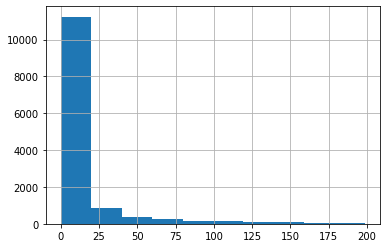

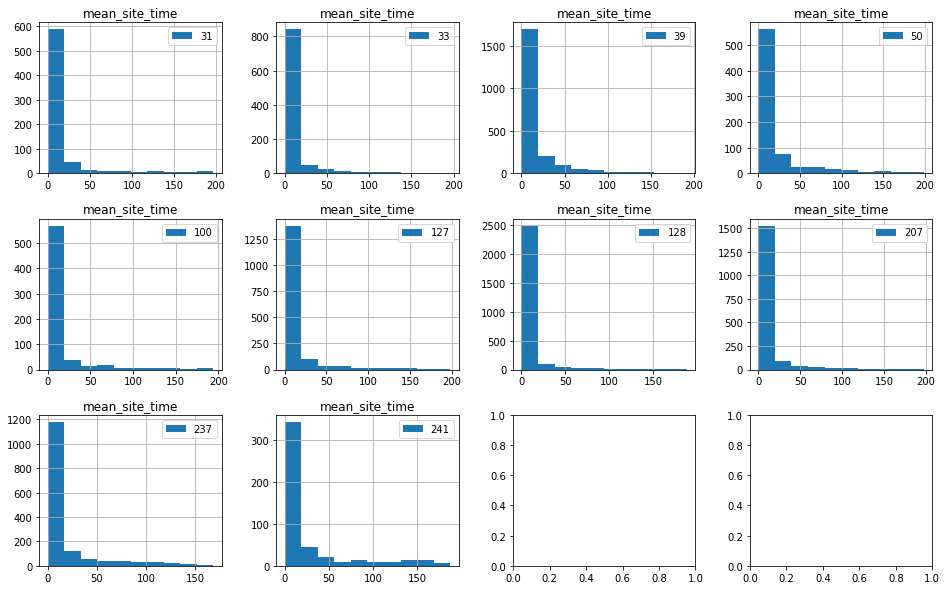

median_site_time


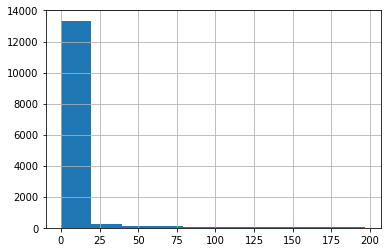

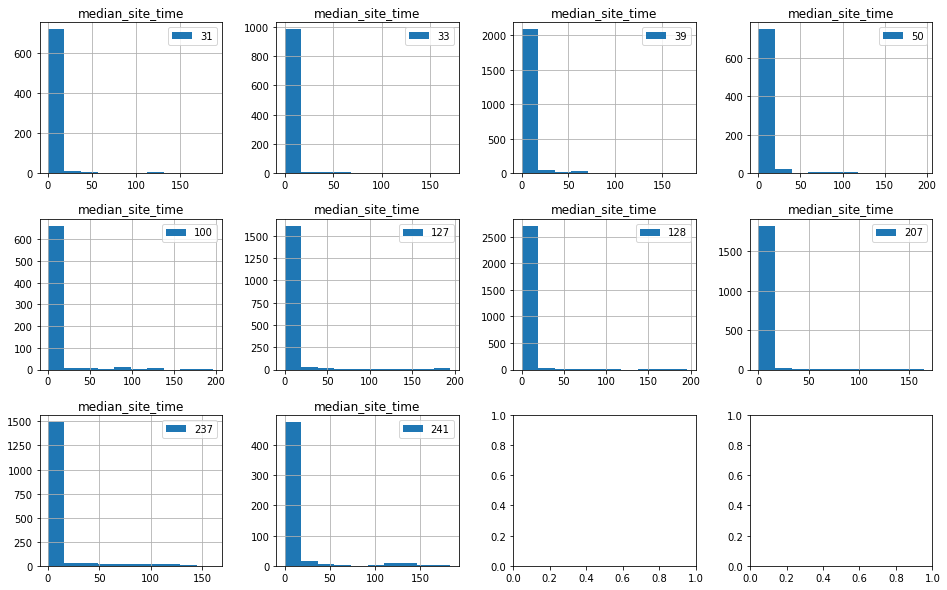

In [85]:
# Перейдем снова к числовым идентификаторам пользователей

# Построим все графики, а потом прокомментируем
feats = ['start_year', 'start_month', 'start_day', 'time_of_the_day', 'weekend', 'mean_site_time', 'median_site_time']

for feat in feats:
    print(feat)
    if feat in ['mean_site_time', 'median_site_time']:
        series = new_features_10users[new_features_10users[feat] < 200][[feat, 'userid']]
    else:
        series = new_features_10users[[feat, 'userid']]
    series[feat].hist()
    plt.show()
    
    if feat == 'time_of_the_day':
        continue
    fig, axes = plt.subplots(nrows=3, ncols=4, figsize=(16, 10))
    for idx, (user, sub_df) in  enumerate(series.groupby('userid')):
        ax = axes[idx // 4, idx % 4]
        sub_df.hist(ax=ax)    
        ax.legend([user])
    plt.show()

На данном датасете кажется, что 'start_year' и 'start_month' почти бесполезны, потому что период меньше одного календарного года. Нет данных за какой-то длительный срок.

'start_day' имеет уникальное распределение для каждого пользователя, как и день недели, и может оказаться весьма полезной

'time_of_the_day' показывает, что никто из пользователей не сидит в интернете ночью. Может помочь сгруппировать пользователей по преимущественному времени активности и помочь модели.

'weekend' озволяет точно отделить пользователей, которые не имеют активности в выходные

'mean_site_time', 'median_site_time' показывают, что в основном у пользователей преобладают короткие посещения сайтов. Ее полезность для модели можно будет оценить при обучении.

**В конце сохраните в pickle-файлы только те признаки, которые, как Вы предполагаете, помогут идентифицировать пользователя более точно. Это касается и признаков, которые мы вместе создали в начале (*session_timespan, #unique_sites, start_hour, day_of_week*), и Ваших собственных. Можно создать все эти признаки не только для сессий из 10 сайтов, но и для других сочетаний параметров *session_length* и *window_size*.**

In [68]:
new_feature_names = ['site' + str(i) for i in range(1,11)] + \
                ['time_diff' + str(j) for j in range(1,10)] + \
                ['session_timespan', '#unique_sites', 'start_hour', 
                 'day_of_week', 'start_time', 'userid', 'start_year', 
                 'start_month', 'start_day', 'time_of_the_day', 'weekend', 
                 'mean_site_time', 'median_site_time']
# userid дропнем потом, если надо. На самом деле, лучше было бы добавить сюда и разреженные признаки, которые получили на прошлой неделе.
selected_features_10users = new_features_10users[new_feature_names]
selected_features_150users = new_features_150users[new_feature_names]

In [69]:
with open(os.path.join(PATH_TO_DATA, 
                       'selected_features_10users.pkl'), 'wb') as selected_features_10users_pkl:
    pickle.dump(selected_features_10users, selected_features_10users_pkl, 
                protocol=2)
with open(os.path.join(PATH_TO_DATA, 
                       'selected_features_150users.pkl'), 'wb') as selected_features_150users_pkl:
    pickle.dump(selected_features_150users, selected_features_150users_pkl, 
                protocol=2)

## Критерии оценки работы:
- Верно ли отображена гистограмма session_timespan из п. 1? (max. 3 балла)
- Верно ли отображена гистограмма #unique_sites из п. 2? (max. 3 балла)
- Верно ли отображены гистограммы #unique_sites по каждому пользователю из п. 3? (max. 6 баллов)
- Верно ли отображена гистограмма start_hour из п. 4? (max. 3 балла)
- Верно ли отображены гистограммы start_hour по каждому пользователю из п. 5? (max. 6 баллов)
- Верно ли отображена гистограмма day_of_week из п. 6? (max. 3 балла)
- Верно ли отображены гистограммы day_of_week по каждому пользователю из п. 7? (max. 6 баллов)
- Насколько сделанные выводы в п. 8 соответствуют построенным картинкам? (max. 6 баллов)
- Верно ли отображен barplot для 10 популярных сайтов из п. 9? (max. 6 баллов)
- Правильно ли посчитана медианная продолжительность сессий в п. 10? (max. 3 балла)
- Правильно ли посчитан медианный день недели начала сессии в п. 11? (max. 3 балла)
- Правильно ли посчитан медианный час начала сессии в п. 12? (max. 3 балла)
- Правильно ли посчитано медианное значение числа уникальных сайтов в сессиях 150 пользователей п. 13? (max. 3 балла)
- Есть ли оригинальные построенные признаки и картинки к ним? Оцените также и качество картинок. (max. 8 баллов)

## Пути улучшения
7 неделя посвящена общему описанию проекта (`html`, `ipynb` или `pdf`) и взаимному оцениванию. Что еще можно добавить по 3 части проекта:
- IPython-widgets, интерактив и анимация (стоящие статьи по этому ремеслу – [раз](https://habrahabr.ru/post/308162/) и  [два](https://habrahabr.ru/company/ods/blog/323210/))
- можно попробовать изобразить исходные данные в некотором пространстве, например, Word2Vec, потом выделить главные компоненты или t-SNE  (только пользуйтесь эффективными реализациями типа [Multicore-TSNE](https://github.com/DmitryUlyanov/Multicore-TSNE), не Sklearn) и раскрасить по целевому классу. Но нет гарантий, что получится что-то значимо отличающееся от каши

На следующей неделе мы наконец приступим к обучению моделей классификации. 